# Web Traffic Analysis
This covers the web traffic analysis of the iNethi network at three vantage points (mesh, school, servers)

In [32]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import calendar
from scipy.stats import describe
from scipy import stats
from user_agents import parse

import seaborn as sns
#sns.set(style="ticks", palette="pastel")

plt.style.use('default')

def hitCount(df, fieldname):
    df = df.groupby(['date']).count()[['ip_src']]
    df.index = pd.to_datetime(df.index, dayfirst=False,  errors='coerce')
    df.columns=[fieldname]
    df = df.resample('D').sum()
    df = df.reset_index()
    return df

def sumTraffic(df, fieldname):
    df = df.groupby(['date']).sum()[['frame_len']]
    df.index = pd.to_datetime(df.index, dayfirst=False,  errors='coerce')
    df.columns=[fieldname]
    df = df.resample('D').sum()
    df = df[[fieldname]].div(1e+9, axis=0)
    df = df.reset_index()
    return df

def extractLocalTraffic(df):
    df_local = df.loc[df.ip_dst.str.startswith('10.', na=False)]
    df_local = df_local.loc[df_local.ip_src.str.startswith('10.', na=False)]
    return df_local

def extractGlobalTraffic(df):
    df_global = df.loc[df.ip_src.str.startswith('10.', na=False)]
    df_global = df_global.loc[~(df_global.ip_dst.str.startswith('10.', na=False))]
    return df_global

# def extractLocalTraffic(df, fieldname):
#     df_local = df.loc[df.ip_dst.str.startswith('10.', na=False)]
#     df_local = df_local.loc[df_local.ip_src.str.startswith('10.', na=False)]
#     df_local = df_local.groupby(['date']).count()[['ip_src']]
#     df_local.index = pd.to_datetime(df_local.index, dayfirst=False,  errors='coerce')
#     df_local.columns=[fieldname]
#     df_local = df_local.resample('D').sum()
#     df_local = df_local.reset_index()
#     return df_local

# def extractGlobalTraffic(df, fieldname):
#     df_global = df.loc[~(df.ip_dst.str.startswith('10.', na=False))]
#     df_global = df_global.loc[df_global.ip_src.str.startswith('10.', na=False)]
#     df_global = df_global.groupby(['date']).count()[['ip_src']]
#     df_global.index = pd.to_datetime(df_global.index, dayfirst=False, errors='coerce')
#     df_global.columns=[fieldname]
#     df_global = df_global.resample('D').sum()
#     df_global = df_global.reset_index()
#     return df_global


In [ ]:
df_school = pd.read_csv('data/stats/http/school.csv', sep='|', error_bad_lines=False, warn_bad_lines=False)
df_servers = pd.read_csv('data/stats/http/servers.csv', sep='|', error_bad_lines=False, warn_bad_lines=False)

In [5]:
df_mesh = pd.read_csv('data/stats/http/mesh.csv', sep=',', error_bad_lines=False, warn_bad_lines=False)

/Users/amreesh/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## User-agents
Study the different types of user-agents and extract the phone and browser used

In [6]:
df_uas = pd.DataFrame(columns=['ua', 'brand', 'os', 'browser', 'mobile', 'tablet', 'pc', 'bot','touch'])

ua_mesh_array = np.array(df_mesh.user_agent.unique())
ua_school_array = np.array(df_school.user_agent.unique())
ua_servers_array = np.array(df_servers.user_agent.unique())

ua_array = np.concatenate((ua_mesh_array, ua_school_array, ua_servers_array), axis=0)

ua_array = ua_array[~pd.isnull(ua_array)]

for ua_string in ua_array:
    user_agent = parse(ua_string)
    summary = str(user_agent)
    df_uas = df_uas.append({'ua' : ua_string, 
                           'brand': summary.split('/')[0] , 
                           'os': summary.split('/')[1] , 
                           'browser': summary.split('/')[2], 
                           'mobile': user_agent.is_mobile, 
                           'tablet': user_agent.is_tablet , 
                           'pc': user_agent.is_pc, 
                           'bot': user_agent.is_bot,
                           'touch': user_agent.is_touch_capable}, ignore_index=True)
df_uas.head()

,ua,brand,os,browser,mobile,tablet,pc,bot,touch
0,Avast NCC,Other,Other,Other,False,False,False,False,False
1,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,PC,Linux,Chrome 60.0.3112,False,False,True,False,False
2,Dalvik/1.6.0 (Linux; U; Android 4.3; GT-I9500 ...,Samsung GT-I9500,Android 4.3,Android 4.3,False,True,False,False,True
3,Dalvik/2.1.0 (Linux; U; Android 8.1.0; ASTRO B...,ASTRO,Android 8.1.0,Android 8.1.0,False,True,False,False,True
4,Dalvik/2.1.0 (Linux; U; Android 7.0; S61 JAZZ ...,S61 JAZZ,Android 7.0,Android 7.0,False,True,False,False,True


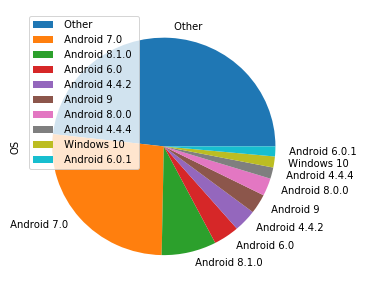

In [7]:
#fig, ax = plt.subplots(figsize=(5, 5))

ax = df_uas.groupby(['os']).count()[['ua']].sort_values('ua', ascending=False)[:10].plot(x='os', y='ua', kind='pie', label='OS', figsize=(5, 5))

# plt.legend(loc='best')
# plt.savefig('plots/pie_os_distribution.pdf')
# plt.show()


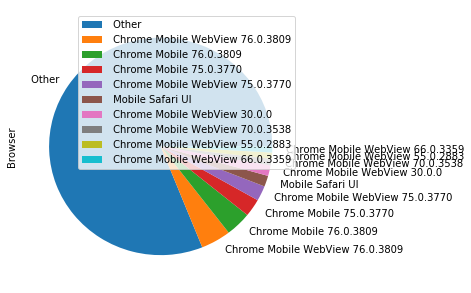

In [8]:
df_browser = df_uas.loc[~df_uas.browser.str.startswith(' Android')]

df_browser.groupby(['browser']).count()[['ua']].sort_values('ua', ascending=False)[:10].plot(x='browser', y='ua', kind='pie', figsize=(5, 5), label='Browser')

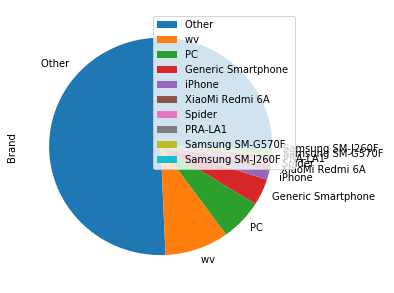

In [9]:
df_browser.groupby(['brand']).count()[['ua']].sort_values('ua', ascending=False)[:10].plot(x='brand', y='ua', kind='pie', figsize=(5, 5), label='Brand')

### Hits on local vs global services

In [33]:
df_local_mesh = extractLocalTraffic(df_mesh)
df_global_mesh = extractGlobalTraffic(df_mesh)

In [19]:
df_local_mesh_sum = sumTraffic(df_local_mesh, 'traffic')
df_global_mesh_sum = sumTraffic(df_global_mesh, 'traffic')

In [22]:
df_local_school = extractLocalTraffic(df_school)
df_global_school = extractGlobalTraffic(df_school)
df_local_school_sum = sumTraffic(df_local_school, 'traffic')
df_global_school_sum = sumTraffic(df_global_school, 'traffic')

#### Mesh Local vs External traffic

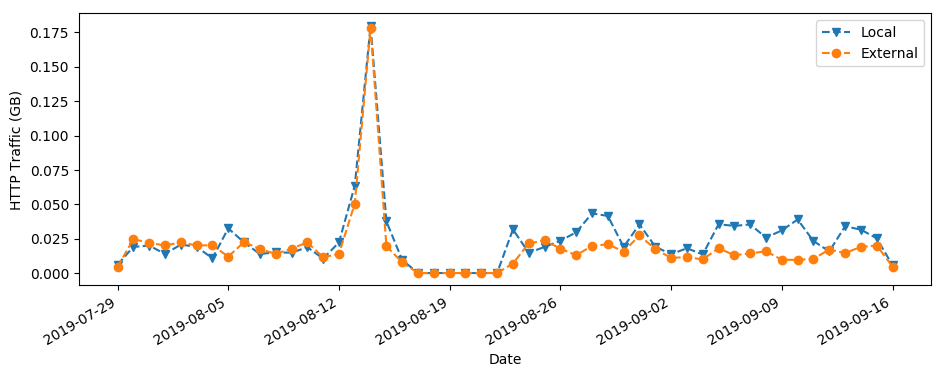

In [27]:
fig, ax = plt.subplots(figsize=(11, 4))

# df_local_mesh.plot(ax, x="date", y=["mesh"], kind="line", marker='.', linestyle='-', )
# df_local_school.plot(ax, x="date", y=["school"], kind="line", marker='.', linestyle='-')
# df_local_servers.plot(ax, x="date", y=["servers"], kind="line", marker='.', linestyle='-')

ax.plot(df_local_mesh_sum.date, df_local_mesh_sum.traffic, marker='v', linestyle='--', label='Local')
ax.plot(df_global_mesh_sum.date, df_global_mesh_sum.traffic, marker='o', linestyle='--', label='External')

ax.set_ylabel('HTTP Traffic (GB)')
ax.set_xlabel('Date')
#ax.set_yscale('symlog')
fig.autofmt_xdate()

ax.legend()

plt.savefig('plots/http_daily_traffic_mesh.pdf')
plt.show()

#### School Local vs External traffic

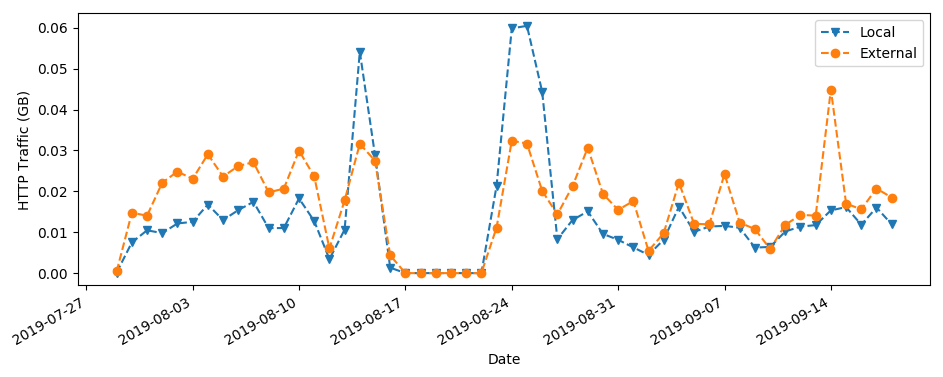

In [28]:
fig, ax = plt.subplots(figsize=(11, 4))

ax.plot(df_local_school_sum.date, df_local_school_sum.traffic, marker='v', linestyle='--', label='Local')
ax.plot(df_global_school_sum.date, df_global_school_sum.traffic, marker='o', linestyle='--', label='External')

ax.set_ylabel('HTTP Traffic (GB)')
ax.set_xlabel('Date')
#ax.set_yscale('symlog')
fig.autofmt_xdate()

ax.legend()

plt.savefig('plots/http_daily_traffic_school.pdf')
plt.show()

#### Servers Local vs External

In [25]:
df_local_servers = extractLocalTraffic(df_servers)
df_global_servers = extractGlobalTraffic(df_servers)
df_local_servers_sum = sumTraffic(df_local_servers, 'traffic')
df_global_servers_sum = sumTraffic(df_global_servers, 'traffic')

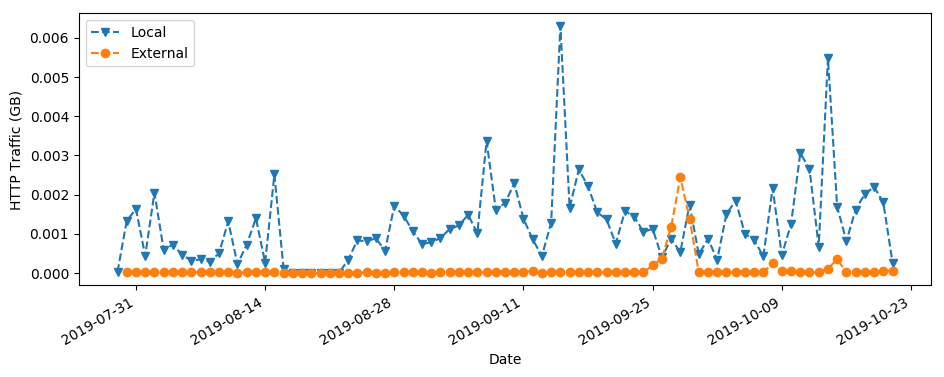

In [29]:
fig, ax = plt.subplots(figsize=(11, 4))

ax.plot(df_local_servers_sum.date, df_local_servers_sum.traffic, marker='v', linestyle='--', label='Local')
ax.plot(df_global_servers_sum.date, df_global_servers_sum.traffic, marker='o', linestyle='--', label='External')

ax.set_ylabel('HTTP Traffic (GB)')
ax.set_xlabel('Date')
#ax.set_yscale('symlog')
fig.autofmt_xdate()

ax.legend()

plt.savefig('plots/http_daily_traffic_servers.pdf')
plt.show()

### Most visited websites (External)
#### Mesh

In [42]:
df_global_mesh.tail()

,date,ip_src,srcport,ip_dst,dstport,request_version,request_method,host,request_uri,user_agent,response_code,content_type,content_length,location,referer,request_full_uri,frame_len,http_time
6764201,2019-09-16 03:02:50,10.10.165.183,60431.0,183.61.112.106,80.0,HTTP/1.1,POST,goupdate.3g.cn,/GOClientData/DR?ptl=10&is_zip=1,Dalvik/1.6.0 (Linux; U; Android 4.4.4; MediaPa...,NaN,application/x-www-form-urlencoded,3744,NaN,NaN,http://goupdate.3g.cn/GOClientData/DR?ptl=10&i...,1114.0,NaN
6764205,2019-09-16 03:02:50,10.10.165.183,60433.0,183.61.112.106,80.0,HTTP/1.1,POST,goupdate.3g.cn,/GOClientData/DR?ptl=10&is_zip=1,Dalvik/1.6.0 (Linux; U; Android 4.4.4; MediaPa...,NaN,application/x-www-form-urlencoded,3744,NaN,NaN,http://goupdate.3g.cn/GOClientData/DR?ptl=10&i...,1114.0,NaN
6764209,2019-09-16 03:02:50,10.10.165.183,60435.0,183.61.112.106,80.0,HTTP/1.1,POST,goupdate.3g.cn,/GOClientData/DR?ptl=10&is_zip=1,Dalvik/1.6.0 (Linux; U; Android 4.4.4; MediaPa...,NaN,application/x-www-form-urlencoded,3914,NaN,NaN,http://goupdate.3g.cn/GOClientData/DR?ptl=10&i...,1284.0,NaN
6764213,2019-09-16 03:02:50,10.10.165.183,60437.0,183.61.112.106,80.0,HTTP/1.1,POST,goupdate.3g.cn,/GOClientData/DR?ptl=10&is_zip=1,Dalvik/1.6.0 (Linux; U; Android 4.4.4; MediaPa...,NaN,application/x-www-form-urlencoded,3914,NaN,NaN,http://goupdate.3g.cn/GOClientData/DR?ptl=10&i...,1284.0,NaN
6764217,2019-09-16 03:02:50,10.10.165.183,60439.0,183.61.112.106,80.0,HTTP/1.1,POST,goupdate.3g.cn,/GOClientData/DR?ptl=10&is_zip=1,Dalvik/1.6.0 (Linux; U; Android 4.4.4; MediaPa...,NaN,application/x-www-form-urlencoded,3914,NaN,NaN,http://goupdate.3g.cn/GOClientData/DR?ptl=10&i...,1284.0,NaN


In [51]:
#df_global_mesh['short_host'] = df_global_mesh.apply(lambda x: '.'.join(x.host.split('.')[-2:]), axis=1)
df_mv_hosts = df_global_mesh.groupby(['host']).sum()[['frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts = df_mv_hosts.reset_index()
df_mv_hosts['frame_len'] = df_mv_hosts.frame_len/1e+9
df_mv_hosts.head(40)

,host,frame_len
0,ad.leadboltapps.net,0.196834
1,239.255.255.250:1900,0.074458
2,koa-global.kingsgroupgames.com,0.061398
3,cdn.samsungcloudsolution.com,0.054949
4,connectivitycheck.gstatic.com,0.038473
5,au.b1.download.windowsupdate.com,0.022440
6,p16.muscdn.com,0.017331
7,goupdate.3g.cn,0.015806
8,connectivitycheck.android.com,0.015286
9,ipv4-c003-cpt001-telkomsa-isp.1.oca.nflxvideo.net,0.015012


In [52]:
df_mv_hosts['short_host'] = df_mv_hosts.apply(lambda x: '.'.join(x.host.split('.')[-2:]), axis=1)
df_mv_hosts = df_mv_hosts.groupby(['short_host']).sum()[['frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts.head(15)

,frame_len
short_host,
leadboltapps.net,0.196834
255.250:1900,0.074459
nflxvideo.net,0.067113
kingsgroupgames.com,0.063186
samsungcloudsolution.com,0.055018
avast.com,0.045903
gstatic.com,0.038693
muscdn.com,0.038167
google.com,0.028182


In [54]:
df_mv_hosts = df_mv_hosts.reset_index()

In [55]:
df_mv_hosts[df_mv_hosts.short_host=='youtube.com']

,short_host,frame_len
167,youtube.com,0.000124


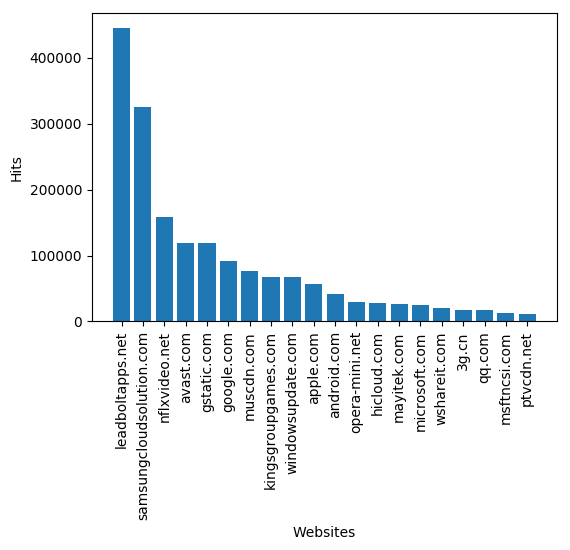

In [248]:
fig, ax = plt.subplots(figsize=(6, 4))

df_list = df_external[:20]

ax.bar(df_list.short_host, df_list.ip_src)

plt.xticks(fontsize=10, rotation='vertical')

ax.set_ylabel('Hits')
ax.set_xlabel('Websites')

plt.savefig('plots/http_hitlists_mesh.pdf')
plt.show()


#### School

In [ ]:
df_school_ext = df_school[df_school['host'].notnull()]
df_school_ext = df_school_ext.loc[~df_school_ext.ip_dst.str.startswith('10.', na=False)]
df_school_ext['short_host'] = df_school_ext.apply(lambda x: '.'.join(x.host.split('.')[-2:]), axis=1)
df_school_ext = df_school_ext.groupby(['short_host']).count()[['ip_src']]
df_school_ext.sort_values(['ip_src'], ascending=False, inplace=True)
#df_school_ext = df_school_ext.drop_duplicates()
df_school_ext = df_school_ext.reset_index()
df_school_ext.head(40)

In [251]:
df_school_ext = df_school_ext.drop([1,23,35])

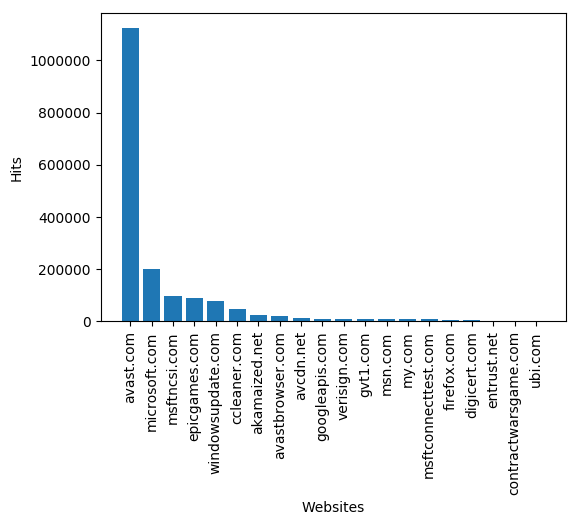

In [253]:
fig, ax = plt.subplots(figsize=(6, 4))

df_list = df_school_ext[:20]

ax.bar(df_list.short_host, df_list.ip_src)

plt.xticks(fontsize=10, rotation='vertical')

ax.set_ylabel('Hits')
ax.set_xlabel('Websites')

plt.savefig('plots/http_hitlists_school.pdf')
plt.show()


#### Servers

In [ ]:
#df_servers_ext = df_servers[df_servers['host'].notnull()]
df_servers_ext = df_servers.loc[~df_servers.ip_dst.str.startswith('10.', na=False)]
df_servers_ext['short_host'] = df_servers_ext.apply(lambda x: '.'.join(x.host.split('.')[-2:]), axis=1)
df_servers_ext = df_servers_ext.groupby(['short_host']).count()[['ip_src']]
df_servers_ext.sort_values(['ip_src'], ascending=False, inplace=True)
#df_school_ext = df_school_ext.drop_duplicates()
df_servers_ext = df_servers_ext.reset_index()
df_servers_ext.head(40)

In [243]:
df_servers_ext = df_servers_ext.drop([1,4,11,14])

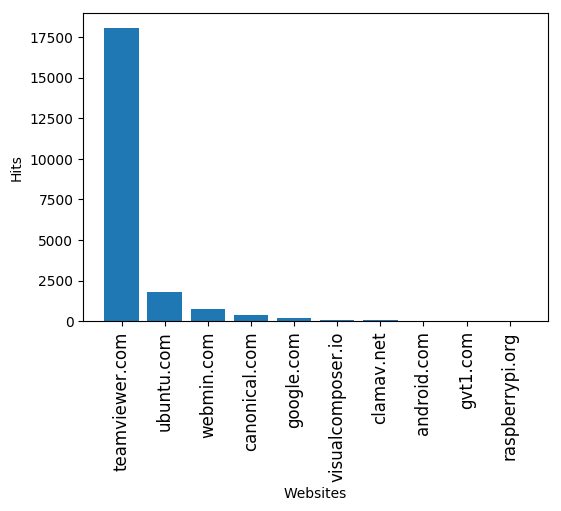

In [252]:
fig, ax = plt.subplots(figsize=(6, 4))

df_list = df_servers_ext[:10]

ax.bar(df_list.short_host, df_list.ip_src)

plt.xticks(fontsize=12, rotation='vertical')

ax.set_ylabel('Hits')
ax.set_xlabel('Websites')

plt.savefig('plots/http_hitlists_servers.pdf')
plt.show()


### Most visited websites (Internal)